In [85]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Checkouts Table

This notebook contains exploratory data analysis (EDA) and preprocessing steps for the `checkouts` table.

The main tasks include:
- Fixing inconsistent or incorrectly formatted checkout and return dates
- Detecting and correcting logical issues, such as return dates that precede checkout dates


## Load checkouts table

In [86]:
file_path = 'data/checkouts.csv'
checkouts_df = pd.read_csv(file_path)
checkouts_df.head()

,id,patron_id,library_id,date_checkout,date_returned
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,2019-01-28,2018-11-13
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24
3,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,2018-01-15,2018-04-25
4,7T9-BAAAQBAJ,2cf3cc3b9e9f6c608767da8d350f77c9,225-222@5xc-jtz-hkf,2018-12-31,1804-01-23


## Fix dates

In [87]:
### Example formats 

# 2019-01-28
# 20180612
# Question - if date returned is empty, does that means books was never returned ? 
# 2018 03 31%
# %2018/11/24
# 2018|07|06%

In [88]:
def str_to_yyyy_mm_dd(val):
    """
    If input is a string of length 8 and all digits, formats it as YYYY-MM-DD.
    Otherwise, returns it unchanged.
    """
    if isinstance(val, str) and len(val) == 8 and val.isdigit():
        return f"{val[:4]}-{val[4:6]}-{val[6:]}"
    return val


#### Fix date formating

In [89]:
# If date checkout is missing, it can not be filled, drop all such rows
checkouts_df = checkouts_df.dropna(subset=['date_checkout'], ignore_index=True)

# Replace '\' and '/' with '-'
checkouts_df['date_checkout'] = checkouts_df['date_checkout'].str.replace(r'[\/|]', '-', regex=True)
checkouts_df['date_returned'] = checkouts_df['date_returned'].str.replace(r'[\/|]', '-', regex=True)

# Replace '%' with '-'
checkouts_df['date_checkout'] = checkouts_df['date_checkout'].str.replace('%', '')
checkouts_df['date_returned'] = checkouts_df['date_returned'].str.replace('%', '')

# Replace trailing spaces
checkouts_df['date_checkout'] = checkouts_df['date_checkout'].str.strip()
checkouts_df['date_returned'] = checkouts_df['date_returned'].str.strip()

# Format 
checkouts_df['date_checkout'] = checkouts_df['date_checkout'].apply(str_to_yyyy_mm_dd)
checkouts_df['date_returned'] = checkouts_df['date_returned'].apply(str_to_yyyy_mm_dd)

# Add '-' to strings formated like 20190128
checkouts_df['date_checkout'] = pd.to_datetime(checkouts_df['date_checkout'], errors='coerce')
checkouts_df['date_returned'] = pd.to_datetime(checkouts_df['date_returned'], errors='coerce')

# Calculate time difference between dates books was taken and returned
checkouts_df['days_diff'] = (checkouts_df['date_returned'] - checkouts_df['date_checkout']).dt.days

In [90]:
# Check distribution of yeats 
# Conclusion - all valid dates come from 2018 and 2019, all other years are most likely typos
checkouts_df['date_returned'].dt.year.value_counts()

date_returned
2018.0    1589
2019.0     104
2112.0      10
2117.0       9
1802.0       8
1807.0       7
1809.0       7
2113.0       7
1819.0       6
1805.0       6
1813.0       6
2111.0       6
2116.0       6
2107.0       5
2114.0       5
2103.0       5
2115.0       5
1812.0       5
2104.0       5
2105.0       5
1804.0       4
2106.0       4
2118.0       4
1815.0       4
1811.0       4
2108.0       3
1806.0       3
2119.0       3
1818.0       3
1808.0       3
2100.0       3
1814.0       3
1800.0       3
2110.0       3
1816.0       2
2102.0       2
1817.0       2
2101.0       2
2120.0       2
1803.0       2
1810.0       2
2109.0       1
1820.0       1
1801.0       1
Name: count, dtype: int64

In [91]:
# All valid samples in this dataset have checkout year = 2018
# Days diff has negative values whenever date checkout is from 2019
checkouts_df[checkouts_df['date_checkout'].dt.year==2019]

,id,patron_id,library_id,date_checkout,date_returned,days_diff
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,2019-01-28,2018-11-13,-76.0
680,PjQDAAAAQAAJ,c6bb1a8f3d393ed0609659d8ae29e534,226-222@5xc-jxj-7yv,2019-01-04,2018-12-25,-10.0
843,__RYAAAAYAAJ,dc10933e4cc9edd0480dbf16044f9832,22c-222@5xc-jwj-pvz,2019-01-17,2018-12-27,-21.0
1229,oFWsXm1zZCcC,3c06873ad81b5b584ee8dee614498cd8,zzw-222@5xc-jv4-789,2019-02-04,2018-09-26,-131.0
1756,PjQDAAAAQAAJ,e785b5a890df9f0e9e0a2b58a5c9c932,224-222@5xc-jw2-t9z,2019-01-27,2018-09-23,-126.0
1903,Q14YAAAAYAAJ,97b774130d1301292f3332a4dca59196,228-222@5xc-jtz-hwk,2019-01-05,2018-12-29,-7.0


#### Attempt to fix typos for years

In [ ]:
# Set up possible valid years for checkout and return
RETURN_VALID_YEARS = (2018, 2019)
VALID_YEAR_CHECKOUT = 2018

def fix_dates(row: pd.Series):
    """
    Fixes/imputes year in returned or checkout
    date whenever this is needed/possible.

    Args:
        row (pd.Series): One df row

    Returns:
        Fixed dates and sample type based on fix.
    """
    
    # Get dates
    date_checkout = row['date_checkout']
    date_return = row['date_returned']
    
    # If row dates are already declared as valid, sample type is valid
    if row['valid']:
        sample_type = 'valid'
    # If row dates are declared as non-reparable, declare sample as invalid
    elif row['invalid']:
        sample_type = 'invalid'
    # Declare samples with missing return date as 'no return'
    elif pd.isna(date_return):
        sample_type = 'no_return'
    
    # If checkout year is not 2018, then set it to 2018 and declate sample as 'checkout_fixed'
    # If, after the fix, days_diff turns out to be negative, declate sample to be invalid
    elif date_checkout.year != VALID_YEAR_CHECKOUT:
        date_checkout = date_checkout.replace(year=VALID_YEAR_CHECKOUT)
        delta = (date_return - date_checkout).days
        
        if delta > 0:
            sample_type = 'checkout_fixed'
        else:
            sample_type = 'invalid'
    
    # If return year is not 2018 or 2019, set it to 2018 or 2019
    # Start by setting return year to checkout year
    # If days_diff turns out to be negative, then set return year to checout year + 1
    elif date_return.year not in RETURN_VALID_YEARS:
        if (date_return.replace(year=date_checkout.year) - date_checkout).days > 0:
            date_return = date_return.replace(year=date_checkout.year) 
            sample_type = 'return_fixed'
        else:
            date_return = date_return.replace(year=date_checkout.year + 1) 
            sample_type = 'return_fixed_up'
            
    else:
        sample_type = 'invalid' 
    
    # Return original/fixed dates and sample type based
    # on how dates were imputed
    return pd.Series({
        'date_checkout_fix': date_checkout,
        'date_returned_fix': date_return,
        'sample_type': sample_type 
    })

In [ ]:
# Check if dates in the sample are completely valid
# Sample is valid when both dates contain valid years and days_diff is not negative
checkouts_df['valid'] = (
    (checkouts_df['days_diff'] > 0) 
    & (checkouts_df['date_checkout'].dt.year == VALID_YEAR_CHECKOUT) 
    & (checkouts_df['date_returned'].dt.year.isin(RETURN_VALID_YEARS))
)

# Check if sample is invalid and dates are imposible to fix
# Sample is declared invalid if date_checkout is missing or if both dates contain valid years byt days_diff is negative
checkouts_df['invalid'] = (
    pd.isna(checkouts_df['date_checkout'])
    | ~((checkouts_df['date_checkout'].dt.year == VALID_YEAR_CHECKOUT) | (checkouts_df['date_returned'].dt.year.isin(RETURN_VALID_YEARS)))
)

# Fix dates
checkouts_df[['date_checkout_fix', 'date_returned_fix', 'sample_type']] = checkouts_df.apply(fix_dates, axis=1)

In [94]:
# Calculate new days_diff based on fixed dates
checkouts_df['fixed_days_diff'] = (checkouts_df['date_returned_fix'] - checkouts_df['date_checkout_fix']).dt.days

In [95]:
# Check distribution of sample types
checkouts_df['sample_type'].value_counts()

sample_type
valid              1435
invalid             163
checkout_fixed       95
return_fixed_up      91
return_fixed         86
no_return            65
Name: count, dtype: int64

## Plot distributions

We can observe that distribution of fixed samples looks different compared to distribution of valid samples.

This possibly indicates that days_diff in fixed samples is of low quality.

<Axes: >

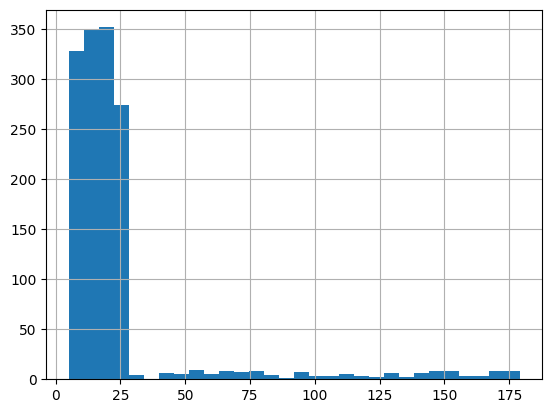

In [96]:
# Distribution of valid samples
checkouts_df.loc[checkouts_df['sample_type']=='valid', 'fixed_days_diff'].hist(bins=30)

<Axes: >

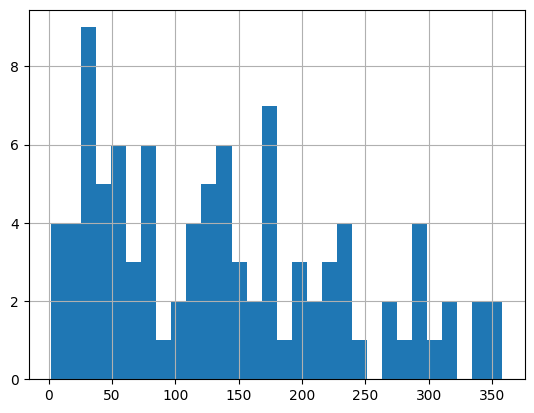

In [ ]:
# Distributions for samples with fixed checkout date
checkouts_df.loc[checkouts_df['sample_type']=='checkout_fixed', 'fixed_days_diff'].hist(bins=30)

<Axes: >

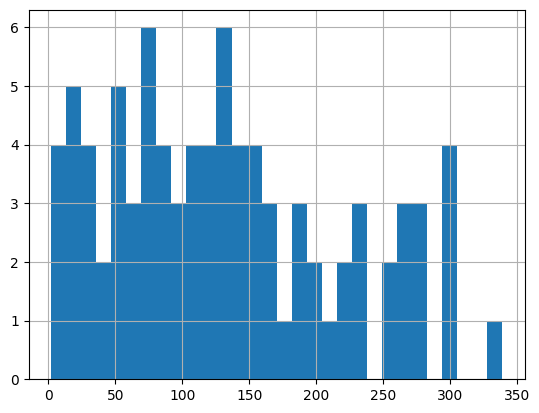

In [ ]:
# Distribution of days_diff for samples with fixed return dates
checkouts_df.loc[checkouts_df['sample_type']=='return_fixed', 'fixed_days_diff'].hist(bins=30)

<Axes: >

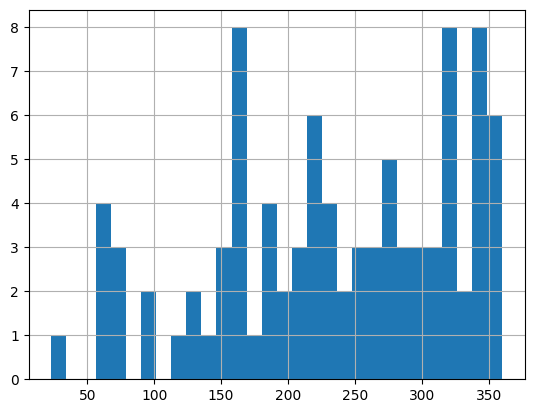

In [ ]:
# Distribution of days_diff for samples with fixed return dates (where we used checkout year + 1 as return year)
checkouts_df.loc[checkouts_df['sample_type']=='return_fixed_up', 'fixed_days_diff'].hist(bins=30)

In [ ]:
# Save processed data to file 
checkouts_df.to_csv('data_preprocessed/checkouts_processed.csv', index=False)